# Modelling with machine learning algorithms

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import shap # pip install -U shap

sns.set()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 200)

In [3]:
df = pd.read_csv('Data/jobcloud_features_v2.csv', sep=';', parse_dates=['start_dt', 'end_dt'])
df.head()

,id,start_dt,end_dt,1d_view_cnt,10d_view_cnt,30d_view_cnt,package_id,industry_name,job_location,job_postal_code,...,title_aggressive,title_female,title_percent,title_location,title_diploma,title_chief,title_prob_en,title_prob_de,title_prob_fr,title_lang
0,8501672,2018-10-25,2018-11-26,0.2372,0.4565,0.7327,B,Industrie diverse,Espace Mittelland,NaN,...,0,1,0,0,0,0,0.0,0.999994,0.0,de
1,8501682,2018-10-25,2018-11-26,0.2883,0.5826,1.0991,B,Maschinen-/Anlagenbau,Region Biel,NaN,...,0,0,0,0,0,0,0.0,0.999996,0.0,de
2,8570830,2018-11-26,2018-12-28,0.1982,0.8468,1.1532,B,Industrie diverse,Espace Mittelland,NaN,...,0,1,0,0,0,0,0.0,0.999994,0.0,de
3,8649301,2019-01-08,2019-02-08,0.2883,0.7177,1.4835,B,Maschinen-/Anlagenbau,Espace Mittelland,NaN,...,0,1,0,0,0,0,0.0,0.999995,0.0,de
4,8730602,2019-02-12,2019-02-21,0.3574,0.7297,0.7297,B,Industrie diverse,Region Biel,NaN,...,0,0,0,0,0,0,0.0,0.999997,0.0,de


In [3]:
df.shape

(101735, 31)

In [4]:
df.columns

Index(['id', 'start_dt', 'end_dt', '1d_view_cnt', '10d_view_cnt',
       '30d_view_cnt', 'package_id', 'industry_name', 'job_location',
       'job_postal_code', 'contract_pct_from', 'contract_pct_to', 'title',
       'title_clean', 'month', 'weekday', 'dayofyear', 'days_online',
       'pct_range', 'city', 'title_num_words', 'title_aggressive',
       'title_female', 'title_percent', 'title_location', 'title_diploma',
       'title_chief', 'title_prob_en', 'title_prob_de', 'title_prob_fr',
       'title_lang'],
      dtype='object')

In [5]:
DAYS = 10
y_col = '%sd_view_cnt' % DAYS

# Select jobs ads which have been online long enough and remove view count outliers
#df = df.loc[df['days_online'] >= DAYS] # (62646, 31)
df = df.loc[(df['days_online'] >= DAYS) & (df[y_col] <= 7.0)]
df.shape

(62623, 31)

In [6]:
features = ['contract_pct_from', 'contract_pct_to', 'month', 'package_id', 'industry_name',# 'days_online', 
            'city', 'title_num_words', 'title_aggressive', 'title_female', 'title_percent',
            'title_location', 'title_diploma', 'title_chief', 'title_prob_en',
            'title_prob_de', 'title_prob_fr']
            # + list(df_doc2vec.columns)
X = pd.get_dummies(df[features], columns=['package_id', 'city', 'industry_name', 'month'])
y = df[y_col]

In [7]:
X.shape

(62623, 61)

In [8]:
X.columns

Index(['contract_pct_from', 'contract_pct_to', 'title_num_words',
       'title_aggressive', 'title_female', 'title_percent', 'title_location',
       'title_diploma', 'title_chief', 'title_prob_en', 'title_prob_de',
       'title_prob_fr', 'package_id_A', 'package_id_B', 'package_id_C',
       'package_id_D', 'city_Aarau', 'city_Basel', 'city_Bern', 'city_Luzern',
       'city_Other', 'city_St. Gallen', 'city_Winterthur', 'city_Zug',
       'city_Zürich', 'industry_name_Banken/ Finanzinstitute',
       'industry_name_Baugewerbe/Immobilien', 'industry_name_Beratung diverse',
       'industry_name_Bildungswesen', 'industry_name_Chemie/Pharma',
       'industry_name_Detail-/Grosshandel',
       'industry_name_Dienstleistungen allgemein',
       'industry_name_Energie-/Wasserwirtschaft',
       'industry_name_Gastgewerbe/Hotellerie',
       'industry_name_Gesundheits-/Sozialwesen',
       'industry_name_Gewerbe/Handwerk allgemein',
       'industry_name_Industrie diverse',
       'industr

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Linear regression

In [19]:
regr = LinearRegression()
cv_scores = cross_val_score(regr, X, y, cv=3, scoring='explained_variance')
cv_scores

array([0.19234178, 0.20067044, 0.18228958])

In [20]:
regr = LinearRegression()
regr.fit(X_train, y_train)
regr.score(X_test, y_test) # explained_variance_score() returns the same as regr.score(X, y)

0.20086808714926352

### Explainability (Shap)

In [21]:
explainer = shap.LinearExplainer(regr, X_train, feature_dependence="correlation")
shap_values = explainer.shap_values(X_test)
shap_values.shape

Estimating transforms: 100%|██████████| 1000/1000 [00:14<00:00, 68.98it/s]


(20666, 61)

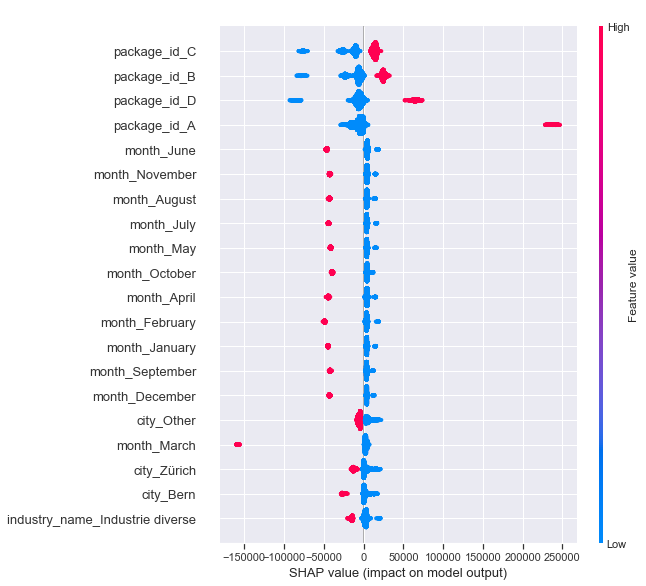

In [22]:
shap.summary_plot(shap_values, X_test)

## Random forest regression with engineered features

### Grid search

In [23]:
param_grid = {
    #'criterion' : ['mse', 'mae'],
    'max_features': ['auto', 'sqrt'],
    'n_estimators':  [10, 50, 100, 200],
    'min_samples_leaf': [2, 10, 50],
    'min_samples_split': [2, 10, 50],
}
#regr = RandomForestRegressor(random_state=42, oob_score=True) 
regr = RandomForestRegressor(random_state=42) 

#regr_cv = GridSearchCV(regr, param_grid=param_grid, cv=4, verbose=20, n_jobs=-1, scoring = 'explained_variance')
regr_cv = RandomizedSearchCV(regr, n_iter=50, param_distributions=param_grid, cv=3, verbose=20, n_jobs=-1, scoring = 'explained_variance')

regr_cv.fit(X, y)
print(regr_cv.best_score_)
print(regr_cv.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

0.21438241778053677
{'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


In [25]:
regr = RandomForestRegressor(random_state=42, n_estimators=50, min_samples_leaf=10)
cv_scores = cross_val_score(regr, X, y, cv=3, scoring='explained_variance')
cv_scores

array([0.18872826, 0.19919057, 0.18721457])

In [26]:
regr = RandomForestRegressor(random_state=42, n_estimators=50, min_samples_leaf=10)
regr.fit(X_train, y_train)
regr.score(X_test, y_test) # explained_variance_score() returns the same as regr.score(X, y)

0.2377277249570039

In [10]:
# Parameters identified with grid search
regr = RandomForestRegressor(random_state=42, n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features='sqrt')
regr.fit(X_train, y_train)
regr.score(X_test, y_test) # explained_variance_score() returns the same as regr.score(X, y)

0.25265893466257383

### Plot predictions

In [11]:
y_pred = regr.predict(X_test)

Text(0,0.5,'predicted')

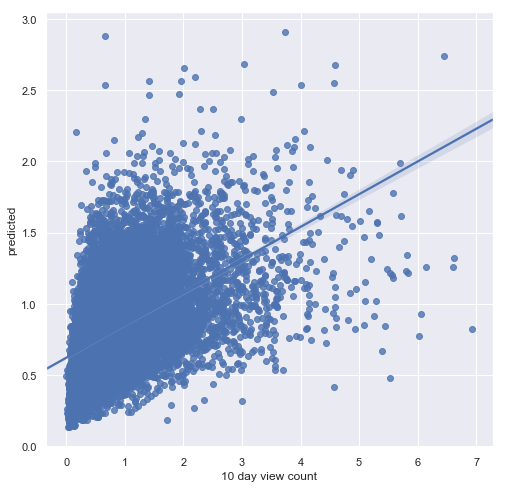

In [12]:
plt.subplots(figsize=(8, 8))
sns.regplot(y_test, y_pred)
plt.xlabel('%s day view count' % DAYS)
plt.ylabel('predicted')

### Feature importance

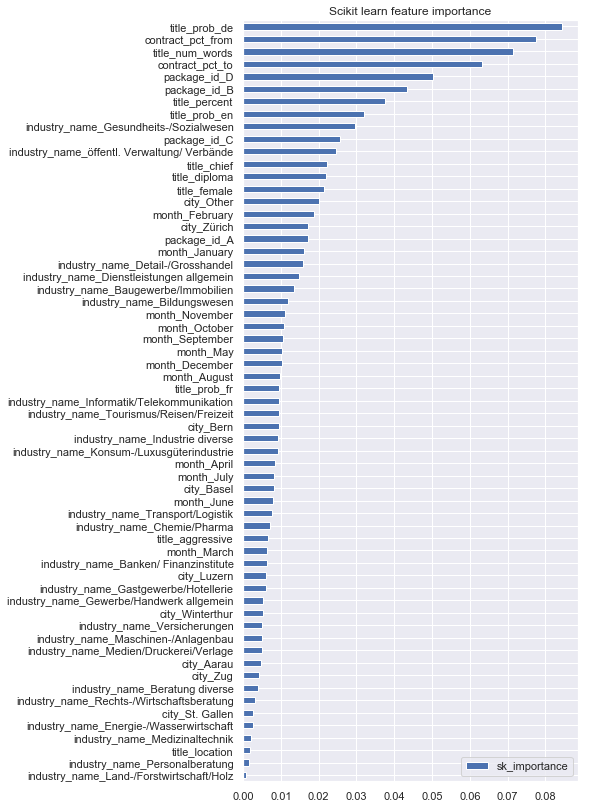

In [13]:
df_importance = pd.DataFrame(regr.feature_importances_, index = X.columns, columns=['sk_importance'])
df_importance.sort_values('sk_importance').plot.barh(figsize=(6, 14));
plt.title('Scikit learn feature importance')
plt.show()

### Explainability (Shap)

In [20]:
# Calculating shap value is expensive, therefore we store them and load them below

# explainer = shap.TreeExplainer(regr)
# X_shap = X_test.sample(500, random_state=42)
# shap_values = explainer.shap_values(X_shap)
# df_shap_values = pd.DataFrame(shap_values)
# df_shap_values.to_csv('Shap/shap_values_random_forest.csv')
# shap_values.shape

In [21]:
shap_values = pd.read_csv('Shap/shap_values_random_forest.csv', index_col=0).values

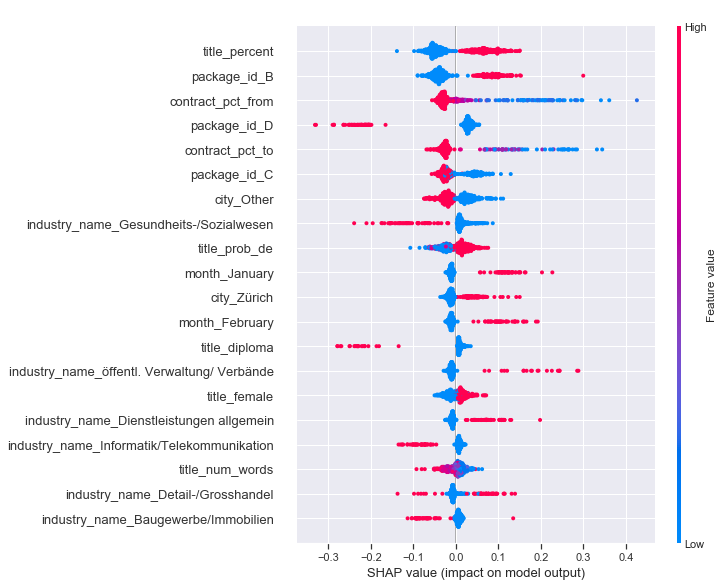

In [15]:
shap.summary_plot(shap_values, X_shap)

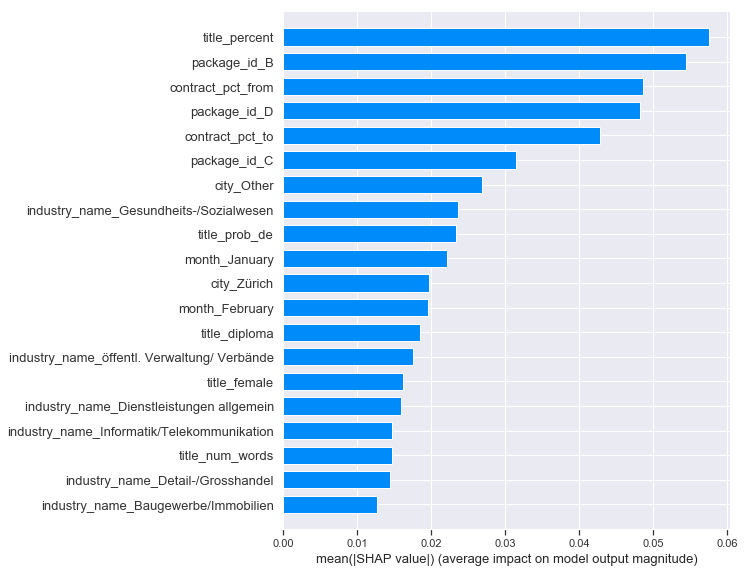

In [16]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

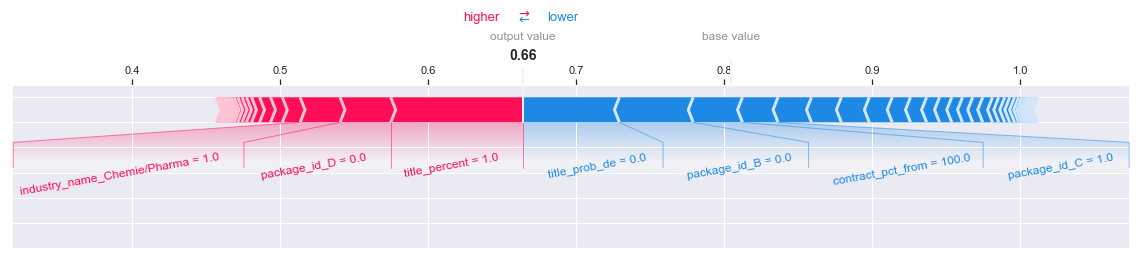

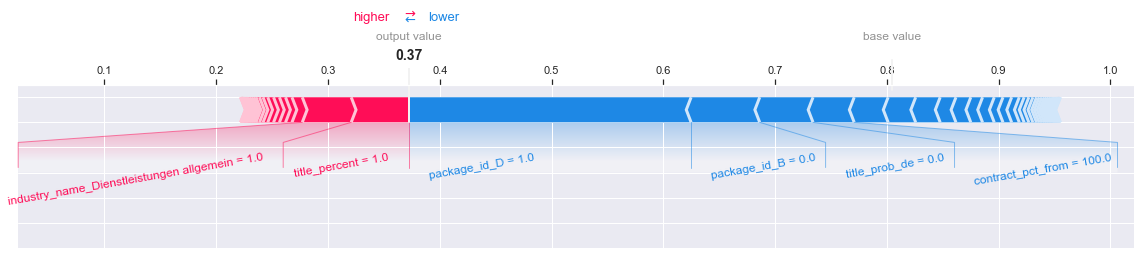

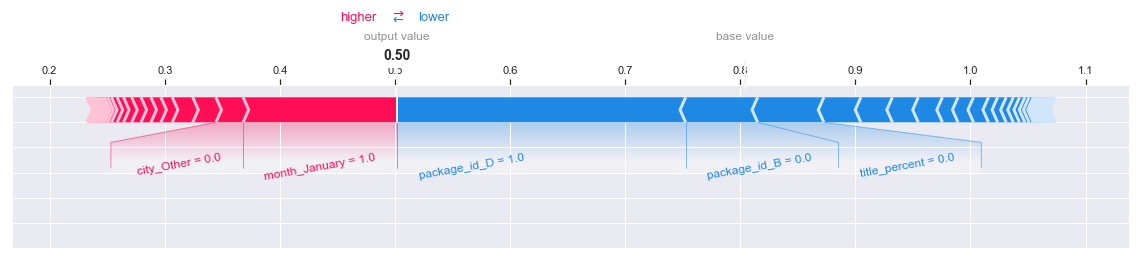

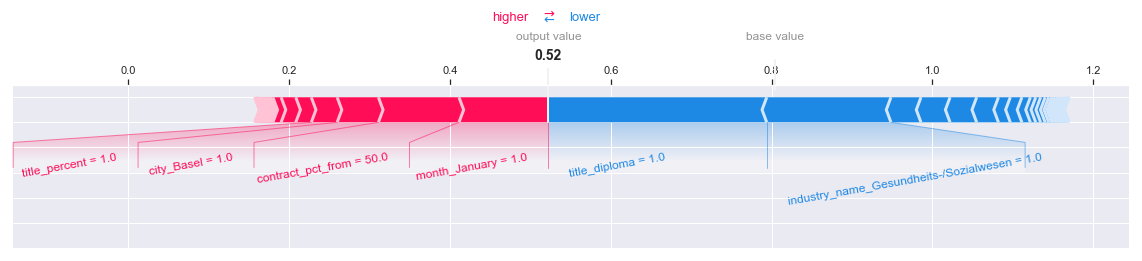

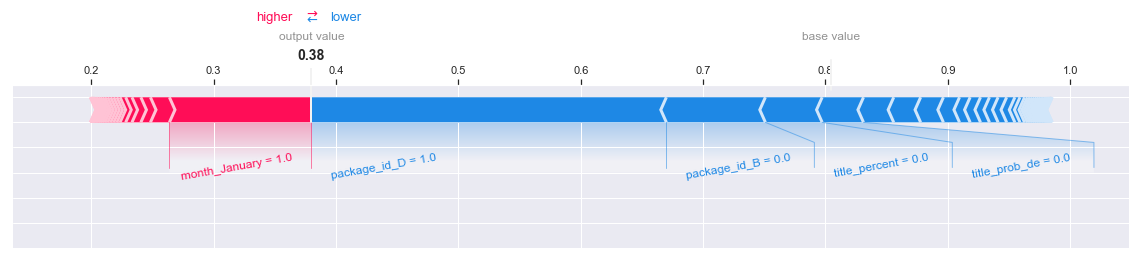

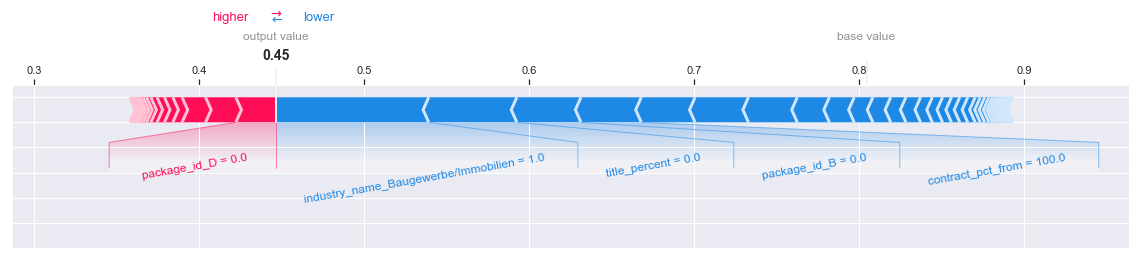

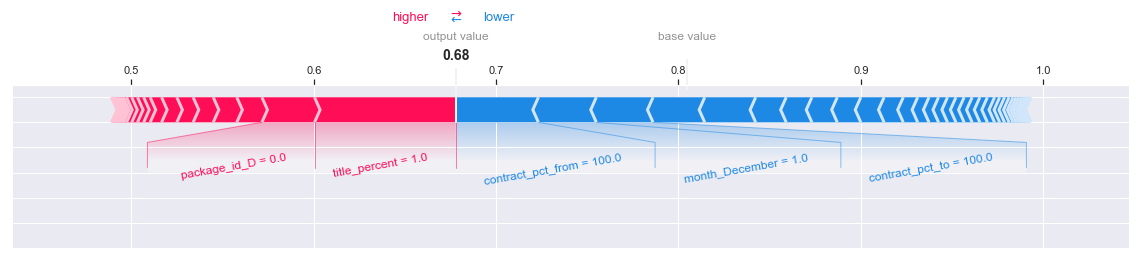

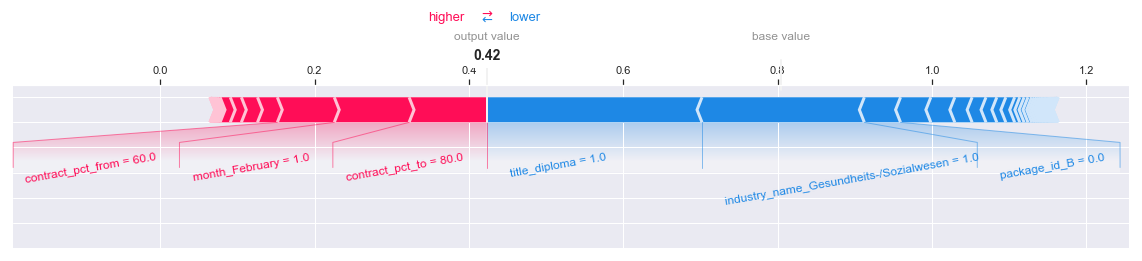

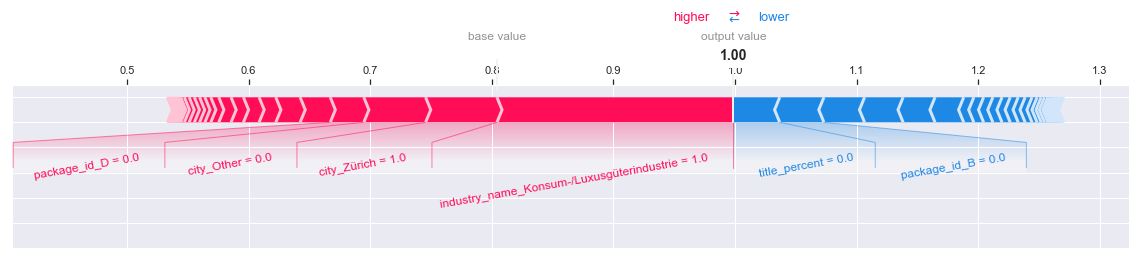

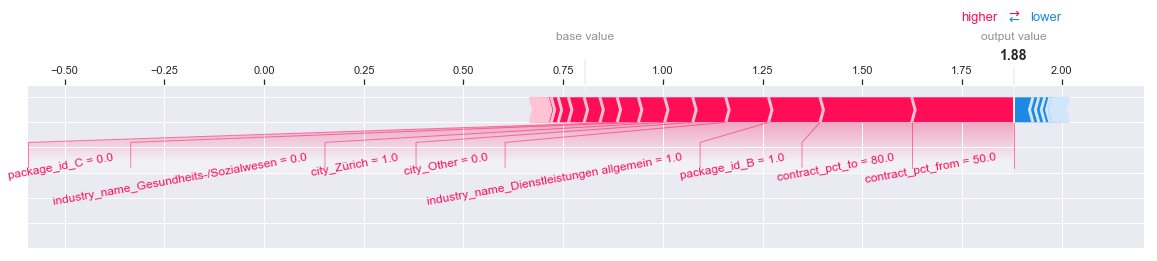

In [17]:
for i in range(10):
    shap.force_plot(explainer.expected_value, shap_values[i, :], np.round(X_shap.iloc[i, :], 3), matplotlib=True, text_rotation=10)

In [18]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_shap)

## Random forest regression including job title embeddings

In [2]:
df = pd.read_csv('Data/jobcloud_features_v2.csv', sep=';', parse_dates=['start_dt', 'end_dt'])
dfe = pd.read_csv('Embeddings/sentence_embeddings_en_clean.csv', index_col=0)

In [3]:
df = pd.concat([df, dfe], axis = 1)
df.shape

(101735, 799)

In [4]:
DAYS = 10
y_col = '%sd_view_cnt' % DAYS

# Select jobs ads which have been online long enough and remove view count outliers
df = df.loc[(df['days_online'] >= DAYS) & (df[y_col] <= 7.0)]
df.shape

(62623, 799)

In [5]:
features = ['contract_pct_from', 'contract_pct_to', 'month', 'package_id', 'industry_name',# 'days_online', 
            'city', 'title_num_words', 'title_aggressive', 'title_female', 'title_percent',
            'title_location', 'title_diploma', 'title_chief', 'title_prob_en',
            'title_prob_de', 'title_prob_fr']
X = pd.get_dummies(df.loc[:, features + list(dfe.columns)], columns=['package_id', 'city', 'industry_name', 'month'])
y = df[y_col]
X.shape

(62623, 829)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41957, 829), (20666, 829), (41957,), (20666,))

In [7]:
# Parameters identified with grid search
regr = RandomForestRegressor(random_state=42, n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features='sqrt')
regr.fit(X_train, y_train)
regr.score(X_test, y_test) # explained_variance_score() returns the same as regr.score(X, y)

0.3405620030612211

In [13]:
y_pred = regr.predict(X_test)
explained_variance_score(y_test, y_pred)

0.340784402905299

### Crossfold validation

In [9]:
regr_cv = RandomForestRegressor(random_state=42, n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features='sqrt')
cv_scores = cross_val_score(regr_cv, X, y, scoring='r2', verbose=1, cv=4, n_jobs=-1)
cv_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.8min finished


array([0.26688948, 0.29439115, 0.29228537, 0.26684071])

### Explainability (Shap)

In [8]:
NUM_SUMMARY_SAMPLES = 1000

X_shap = X_train.sample(NUM_SUMMARY_SAMPLES, random_state=42)
X_shap.shape

(1000, 829)

In [9]:
# Calculating shap value is expensive, therefore we store them and load them below
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_shap)
df_shap_values = pd.DataFrame(shap_values)
df_shap_values.to_csv('Shap/shap_values_random_forest_embeddings.csv')
shap_values.shape

(1000, 829)

In [10]:
shap_values = pd.read_csv('Shap/shap_values_random_forest_embeddings.csv', index_col=0).values
shap_values.shape

(1000, 829)

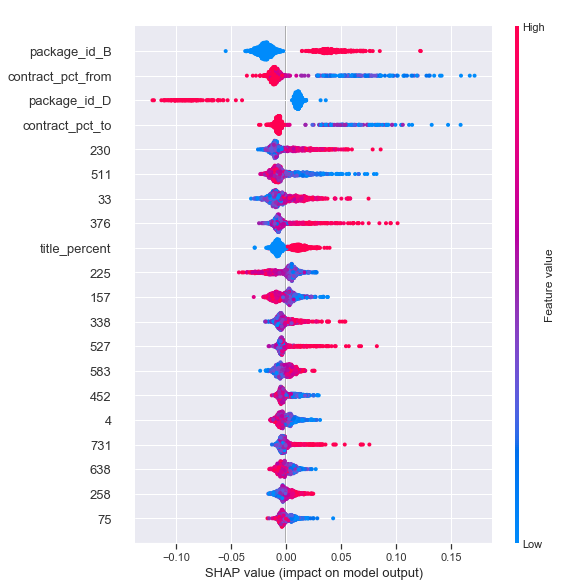

In [11]:
shap.summary_plot(shap_values, X_shap)

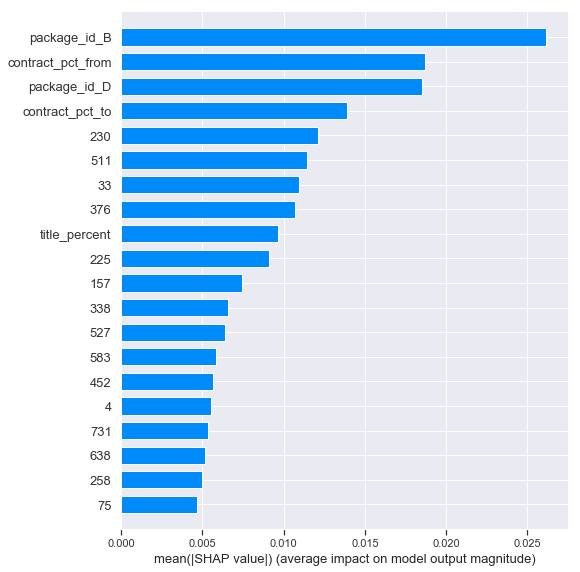

In [12]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")